In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pylab as plt
import glob
import os
from pprint import pprint
import scipy.integrate as inte
import scipy.special as special
import scipy.interpolate as interp
import scipy.signal as sig

In [3]:
import stephane.display.graphes as graphes
import stephane.tools.Smath as smath

import icewave.tools.datafolders as df
import icewave.tools.rw_data as rw_data

#import sympy #symoblic python
#import mpmath as math
#import cv2
import glob
import csv
import os

import icewave.phone.rw_pyphone as rw
import icewave.field.multi_instruments as multi

macOS
laita.pmmh-local.espci.fr
Please install garmin package
macOS

/Volumes/


In [4]:
import urllib

In [5]:
import urllib.request
import subprocess


phonelist = ['00','01','04','05']
network = 2

for phone in phonelist:
    ip = f'192.168.{network}.1{phone}'
    a = subprocess.run(['ping','-c','2',ip],text=True,stdout=True)

PING 192.168.2.100 (192.168.2.100): 56 data bytes
64 bytes from 192.168.2.100: icmp_seq=0 ttl=64 time=115.049 ms
64 bytes from 192.168.2.100: icmp_seq=1 ttl=64 time=2.773 ms

--- 192.168.2.100 ping statistics ---
2 packets transmitted, 2 packets received, 0.0% packet loss
round-trip min/avg/max/stddev = 2.773/58.911/115.049/56.138 ms
PING 192.168.2.101 (192.168.2.101): 56 data bytes
64 bytes from 192.168.2.101: icmp_seq=0 ttl=64 time=122.098 ms
64 bytes from 192.168.2.101: icmp_seq=1 ttl=64 time=37.676 ms

--- 192.168.2.101 ping statistics ---
2 packets transmitted, 2 packets received, 0.0% packet loss
round-trip min/avg/max/stddev = 37.676/79.887/122.098/42.211 ms
PING 192.168.2.104 (192.168.2.104): 56 data bytes
64 bytes from 192.168.2.104: icmp_seq=0 ttl=64 time=92.309 ms
64 bytes from 192.168.2.104: icmp_seq=1 ttl=64 time=14.152 ms

--- 192.168.2.104 ping statistics ---
2 packets transmitted, 2 packets received, 0.0% packet loss
round-trip min/avg/max/stddev = 14.152/53.230/92.309/

In [6]:
def get_ip(phone,network=2):
    return f'192.168.{network}.1{phone}'

In [7]:
# accessible functions
commands = {'start':'/start?name',
            'stop':'/stop',
            'status':'/status',
            'sync':'/kick-sync?threshold'}

In [8]:
#/status
#/kick-sync?threshold
#/kick-time
#/udp-sync
#/test
#/time
#/screen-off
#/list-files
#/get-file/fileName

In [10]:
port = 8080

phonelist = ['00']
for phone in phonelist:
    ip = get_ip(phone)
    a = urllib.request.urlopen(f"http://{ip}:{port}/status").read()
    print(phone,a)

00 b'STOPPED'


URLError: <urlopen error [Errno 61] Connection refused>

In [39]:
import time
# run test recordings of 1 minute
name = 'experiment'
for phone in phonelist:
    print(phone)
    ip = get_ip(phone)
    # Start recording. name is just for naming the files. Not mandatory
    s = urllib.request.urlopen(f"http://{ip}:{port}/start?name={name}").read()
    print(phone,s)
time.sleep(60)

for phone in phonelist:
    print(phone)
    ip = get_ip(phone)
    # Start recording. name is just for naming the files. Not mandatory
    s = urllib.request.urlopen(f"http://{ip}:{port}/stop").read()
    print(phone,s)

00
00 b'Recording experiment experiment-2024-12-03T17_36_46, please stop me'
33
33 b'Recording experiment experiment-2024-12-03T17_36_45, please stop me'
34
34 b'Recording experiment experiment-2024-12-03T17_36_47, please stop me'
00
00 b'Finished'
33
33 b'Finished'
34
34 b'Finished'


In [40]:
import re


datas = {}
for phone in phonelist:
    datas[phone] = {}
    print(phone)
    ip = get_ip(phone)
    port = '8080'
    a = urllib.request.urlopen(f"http://{ip}:{port}/list-files").read()
    s = a.decode('utf-8')
    filelist = s[1:-1].split(', ')
    #pprint(filelist)
    print(filelist)

    rx = re.compile(r'experiment-2024-12-03*')
    filelist = list(filter(rx.search, filelist))
    datas[phone]['filelist']=filelist
    pprint(filelist)

00
['2024-11-26T16-21-52-android.sensor.accelerometer-1-967387526062-968285009285.csv', '2024-11-26T16-21-52-android.sensor.gyroscope-1-967387526062-968285009285.csv', '2024-11-26T16-21-52-android.sensor.magnetic_field-1-967387520558-968287500523.csv', '2024-11-26T16-21-52-gps-1-967436678869-968451741158.csv', '2024-11-26T16-21-52-android.sensor.accelerometer-2-968285011777-969181904071.csv', '2024-11-26T16-21-52-android.sensor.gyroscope-2-968285011777-969181904071.csv', '2024-11-26T16-21-52-android.sensor.magnetic_field-2-968287520527-969187500504.csv', '2024-11-26T16-21-52-gps-2-968452744818-969409734951.csv', 'experiment-2024-12-03T17_08_05-android.sensor.accelerometer-1-1574960464175-1575858187426.csv', 'experiment-2024-12-03T17_08_05-android.sensor.gyroscope-1-1574960504071-1575858227331.csv', 'experiment-2024-12-03T17_08_05-android.sensor.magnetic_field-1-1574960508661-1575860488643.csv', 'experiment-2024-12-03T17_08_05-gps-1-1574960731691-1575859724620.csv', 'experiment-2024-12-

In [41]:
for phone in datas.keys():
    filelist = datas[phone]['filelist']
    datas[phone]['raw'] = {}
    ip = get_ip(phone)
    for filename in filelist:
        print(phone,filename)
        a = urllib.request.urlopen(f"http://{ip}:{port}/get-file/"+filename).read()
        name = filename.split('.')[-2]
        datas[phone]['raw'][name] = a

00 experiment-2024-12-03T17_08_05-android.sensor.accelerometer-1-1574960464175-1575858187426.csv
00 experiment-2024-12-03T17_08_05-android.sensor.gyroscope-1-1574960504071-1575858227331.csv
00 experiment-2024-12-03T17_08_05-android.sensor.magnetic_field-1-1574960508661-1575860488643.csv
00 experiment-2024-12-03T17_08_05-gps-1-1574960731691-1575859724620.csv
00 experiment-2024-12-03T17_26_37-android.sensor.accelerometer-1-1576072458516--1.csv
00 experiment-2024-12-03T17_26_37-android.sensor.gyroscope-1-1576072473480--1.csv
00 experiment-2024-12-03T17_26_37-android.sensor.magnetic_field-1-1576072488639--1.csv
00 experiment-2024-12-03T17_26_37-gps-1-1576072735229--1.csv
00 experiment-2024-12-03T17_36_46-android.sensor.accelerometer-1-1576681648340--1.csv
00 experiment-2024-12-03T17_36_46-android.sensor.gyroscope-1-1576681678272--1.csv
00 experiment-2024-12-03T17_36_46-android.sensor.magnetic_field-1-1576681688624--1.csv
00 experiment-2024-12-03T17_36_46-gps-1-1576681723509--1.csv
33 exper

In [58]:
print(data.keys())

dict_keys(['accelerometer-0-57005192443--1', 'experiment-2024-11-26T07_23_19-gps-0--1--1', 'gyroscope-0-57005192443--1', 'magnetic_field-0-57005177685--1'])


In [42]:
def decode_data(data,v='a'):
    d = data.decode('utf-8')
    lines = d.split('\n')
    d = np.asarray([line.split(', ')[:-1] for line in lines]).astype(float)
    print(d.shape)
    dic = {}
    dic['t'+v] = d[:,0]
    dic[v+'x' ]= d[:,1]
    dic[v+'y'] = d[:,2]
    dic[v+'z'] = d[:,3]
    return dic

In [43]:
for phone in datas.keys():
    datas[phone]['d']={}
    for name in datas[phone]['raw'].keys():
        print(phone,name)
        if 'accelerometer' in name:
            d = datas[phone]['raw'][name]
            dic = decode_data(d,v='a')
            datas[phone]['d'][name] = dic

00 accelerometer-1-1574960464175-1575858187426
(360000, 4)
00 gyroscope-1-1574960504071-1575858227331
00 magnetic_field-1-1574960508661-1575860488643
00 experiment-2024-12-03T17_08_05-gps-1-1574960731691-1575859724620
00 accelerometer-1-1576072458516--1
(360000, 4)
00 gyroscope-1-1576072473480--1
00 magnetic_field-1-1576072488639--1
00 experiment-2024-12-03T17_26_37-gps-1-1576072735229--1
00 accelerometer-1-1576681648340--1
(360000, 4)
00 gyroscope-1-1576681678272--1
00 magnetic_field-1-1576681688624--1
00 experiment-2024-12-03T17_36_46-gps-1-1576681723509--1
33 gyroscope-1-696966554420-697858446396
33 accelerometer-1-696966554420-697858446396
(360000, 4)
33 experiment-2024-12-03T17_08_04-gps-1-696966903059-697865926840
33 magnetic_field-1-696966559526-697885099449
33 accelerometer-1-698077876134--1
(360000, 4)
33 magnetic_field-1-698077899510--1
33 gyroscope-1-698077891001--1
33 experiment-2024-12-03T17_26_36-gps-1-698077906422--1
33 accelerometer-1-698687542383--1
(360000, 4)
33 gyro

In [44]:
datas['00']['d']['accelerometer-1-1574960464175-1575858187426'].keys()

dict_keys(['ta', 'ax', 'ay', 'az'])

0.8483866350931667
0.8525151616185398
0.8482487753045315
0.02208308154111805
0.0598345028782224
0.0817333717693203
0.20132859352135088
0.19873745193760342
0.12485821441300092


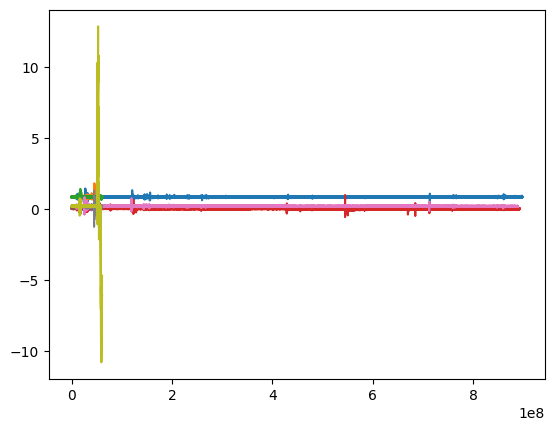

In [47]:
for phone in datas.keys():
    for name in datas[phone]['d'].keys():
        t =  np.asarray(datas[phone]['d'][name]['ta'])
        ax =  np.asarray(datas[phone]['d'][name]['ax'])
        plt.plot(t-t[0],ax)
        print(np.nanmean(ax))

In [36]:


import time
name = 'experiment'
port = 8080

secondes = 60
urllib.request.urlopen(f"http://{ip}:{port}/start?name={name}").read()
t0 = time.time()
for i in range(secondes):
    status = urllib.request.urlopen(f"http://{ip}:{port}/status").read()
    print(i,status)
    time.sleep(1)
urllib.request.urlopen(f"http://{ip}:{port}/stop").read()

status = urllib.request.urlopen(f"http://{ip}:{port}/status").read()
print(i,status)

b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'
b'RECORDING'


b'Finished'

In [77]:
# Poor-man sync. when the accelerometer (in x / directions) will pass the threshold, each phone will take that point in time as its origin
phonelist = [33,34,35]
for phone in phonelist:
    print(phone)
    urllib.request.urlopen(f"http://192.168.{network}.1{phone}:{port}/kick-sync").read()
    
for phone in phonelist:
    print(phone)
    s = urllib.request.urlopen(f"http://192.168.{network}.1{phone}:{port}/kick-time").read()

    print(s)

33
34
35
33
b'58708840485345'
34
b'337839219797248'
35
b'337850561892924'


In [ ]:
for phone in phonelist:
    print(phone)
    urllib.request.urlopen(f"http://192.168.{network}.1{phone}:{port}/kick-sync").read()


In [122]:
# run test recordings of 1 minute
name = 'experiment'
for phone in phonelist:
    print(phone)
    ip = f'192.168.{network}.1{phone}'
# Start recording. name is just for naming the files. Not mandatory
    s = urllib.request.urlopen(f"http://{ip}:{port}/start?name={name}").read()
    print(s)
time.sleep(60)

for phone in phonelist:
    print(phone)
    ip = f'192.168.{network}.1{phone}'
# Start recording. name is just for naming the files. Not mandatory
    s = urllib.request.urlopen(f"http://{ip}:{port}/stop").read()
    print(s)

33
b'Recording experiment experiment-2024-11-26T08_35_17, please stop me'
34
b'Recording experiment experiment-2024-11-26T08_35_20, please stop me'
35
b'Recording experiment experiment-2024-11-26T08_35_20, please stop me'
33
b'Finished'
34
b'Finished'
35
b'Finished'


In [123]:
import re

files = {}
#t = '08_23_' ##good !
t = '08_35_'
for phone in phonelist:
    print(phone)
    ip = f'192.168.{network}.1{phone}'


    a = urllib.request.urlopen(f"http://{ip}:{port}/list-files").read()
    s = a.decode('utf-8')
    filelist = s[1:-1].split(', ')

    rx = re.compile(f'experiment-2024-11-26T{t}*')
    filelist = list(filter(rx.search, filelist)) 
    pprint(filelist)
    files[phone]=filelist


33
['experiment-2024-11-26T08_35_17-android.sensor.accelerometer-0--1--1.csv',
 'experiment-2024-11-26T08_35_17-android.sensor.gyroscope-0--1--1.csv',
 'experiment-2024-11-26T08_35_17-android.sensor.magnetic_field-0--1--1.csv',
 'experiment-2024-11-26T08_35_17-gps-0--1--1.csv']
34
['experiment-2024-11-26T08_35_20-android.sensor.accelerometer-0--1--1.csv',
 'experiment-2024-11-26T08_35_20-android.sensor.gyroscope-0--1--1.csv',
 'experiment-2024-11-26T08_35_20-android.sensor.magnetic_field-0--1--1.csv',
 'experiment-2024-11-26T08_35_20-gps-0--1--1.csv']
35
['experiment-2024-11-26T08_35_20-android.sensor.accelerometer-0--1--1.csv',
 'experiment-2024-11-26T08_35_20-android.sensor.gyroscope-0--1--1.csv',
 'experiment-2024-11-26T08_35_20-android.sensor.magnetic_field-0--1--1.csv',
 'experiment-2024-11-26T08_35_20-gps-0--1--1.csv']


In [124]:
data = {}
for phone in files.keys():
    print(phone)
    ip = f'192.168.{network}.1{phone}'
    filelist = files[phone]
    data[phone]={}
    for filename in filelist:
        print(filename)
        parse = filename.split('.')
        if len(parse)>2:
            v = parse[-2][0]
            print(v)
        else:
            v = 'loc'
        d = urllib.request.urlopen(f"http://{ip}:{port}/get-file/"+filename).read()
        name = filename.split('.')[-2]
        data[phone].update(decode_data(d,v=v))
        print(np.max(data[phone]['ta']))

33
experiment-2024-11-26T08_35_17-android.sensor.accelerometer-0--1--1.csv
a
(360000, 4)
-1.0
experiment-2024-11-26T08_35_17-android.sensor.gyroscope-0--1--1.csv
g
(360000, 4)
-1.0
experiment-2024-11-26T08_35_17-android.sensor.magnetic_field-0--1--1.csv
m
(45000, 4)
-1.0
experiment-2024-11-26T08_35_17-gps-0--1--1.csv
(900, 4)
-1.0
34
experiment-2024-11-26T08_35_20-android.sensor.accelerometer-0--1--1.csv
a
(360000, 4)
-1.0
experiment-2024-11-26T08_35_20-android.sensor.gyroscope-0--1--1.csv
g
(360000, 4)
-1.0
experiment-2024-11-26T08_35_20-android.sensor.magnetic_field-0--1--1.csv
m
(45000, 4)
-1.0
experiment-2024-11-26T08_35_20-gps-0--1--1.csv
(900, 4)
-1.0
35
experiment-2024-11-26T08_35_20-android.sensor.accelerometer-0--1--1.csv
a
(360000, 4)
-1.0
experiment-2024-11-26T08_35_20-android.sensor.gyroscope-0--1--1.csv
g
(360000, 4)
-1.0
experiment-2024-11-26T08_35_20-android.sensor.magnetic_field-0--1--1.csv
m
(45000, 4)
-1.0
experiment-2024-11-26T08_35_20-gps-0--1--1.csv
(900, 4)
-1.0


88.005978
82.424089
75.974002


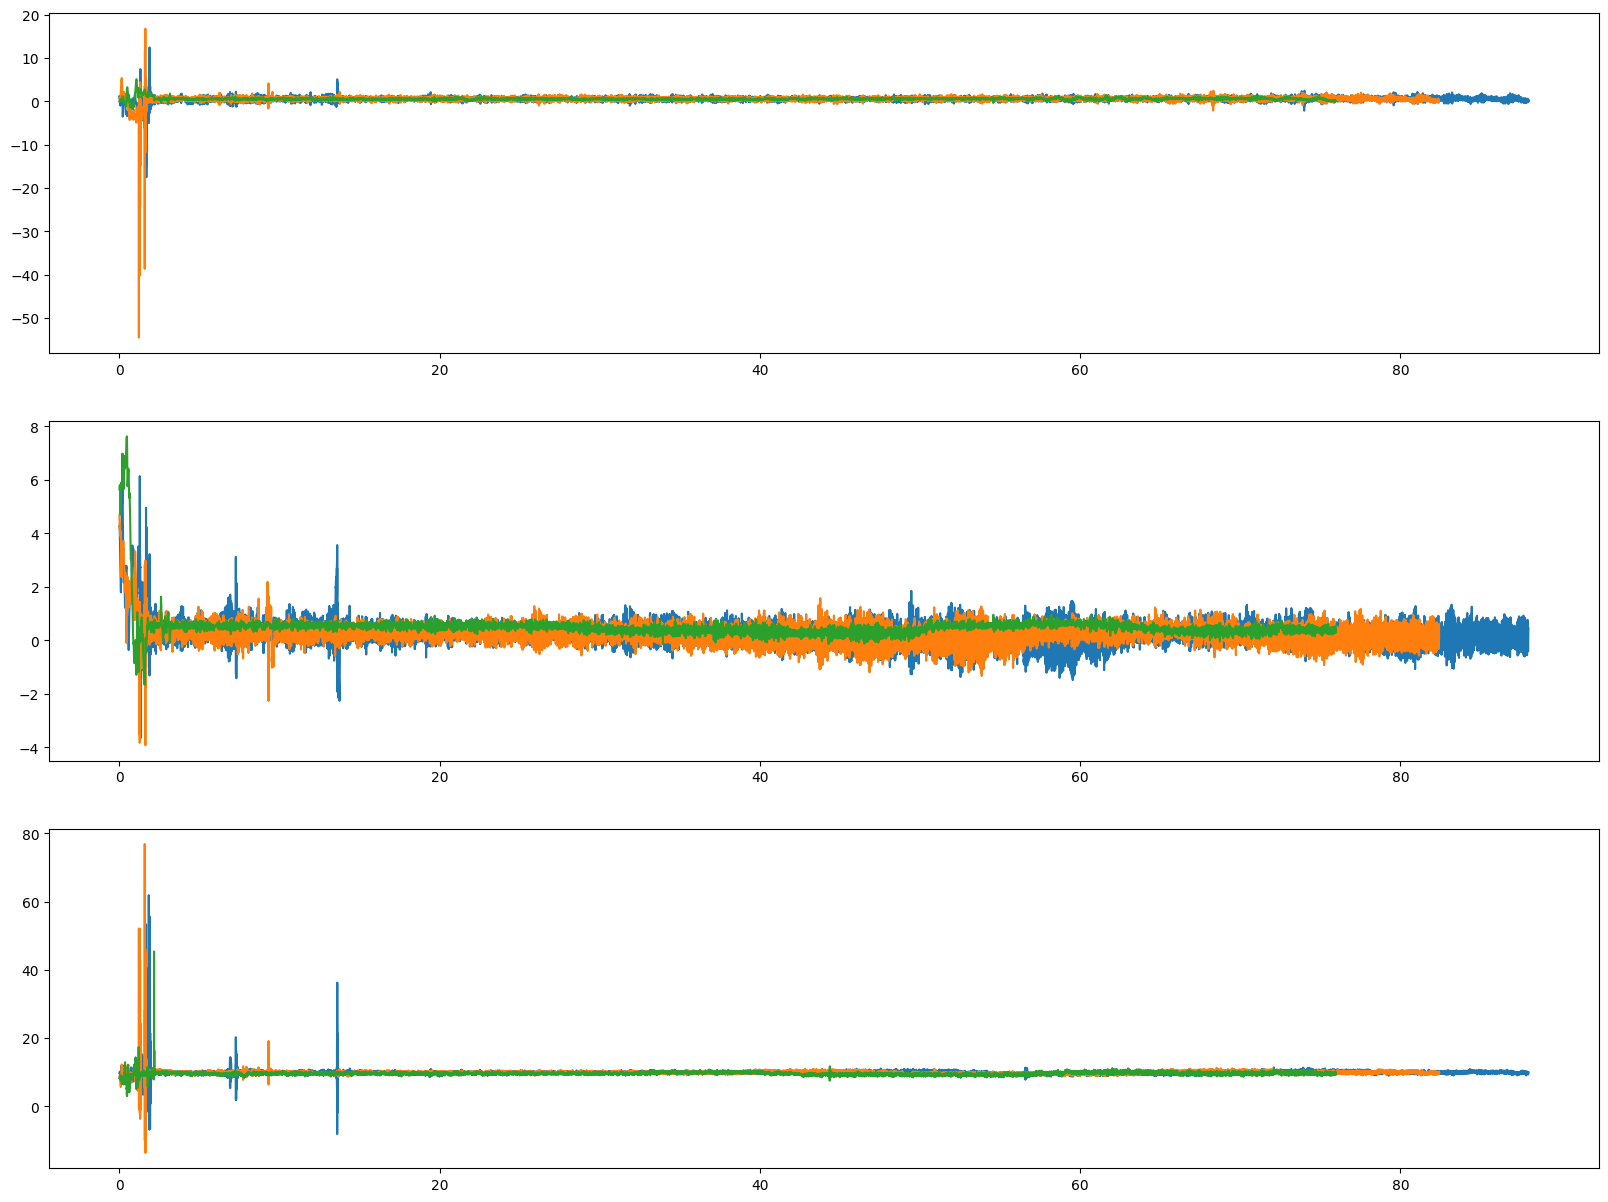

In [119]:
fig,axs = plt.subplots(figsize=(20,15),nrows=3)
coords = ['x','y','z']
for phone in phonelist:
#    print(data[phone].keys())   
    for coord,ax in zip(coords,axs):
        t0 = data[phone]['ta'][0]
        t = (data[phone]['ta']-t0)/10**6
        y = data[phone]['a'+coord]
        ax.plot(t,y)
    print(np.max(t))

In [ ]:
# get the data from the last recording


In [40]:
port = 8080
name = 'experiment'
for phone in phonelist[12:]:
    print(phone)
    ip = f'192.168.2.1{phone}'
# Start recording. name is just for naming the files. Not mandatory
#    urllib.request.urlopen(f"http://{ip}:{port}/start?name={name}").read()
    urllib.request.urlopen(f"http://{ip}:{port}/stop").read()

47
48
49


In [42]:
# get the data
import subprocess

filelist = {}
for phone in phonelist:
    print(phone)
    ip = f'192.168.2.1{phone}'
    files = subprocess.run(['adb','-s',ip, 'shell','ls','storage/self/primary/Download/SensorDumper/*21_*accelero*.csv'],text=True,capture_output = True)#,stdout=True,stderr=True)
    lines = str(files).split("stdout='")[1].split('\\n')
    print(lines[:-1])
    filelist[phone]=lines[:-1]

#adb -s 192.168.2.133 push ~/Documents/Telephones/2024_Jules_Caso/app-release.apk /storage/self/primary/Download/app_JC_20112024.pak

33
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_51-android.sensor.accelerometer-3--1--1.csv']
34
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_52-android.sensor.accelerometer-4--1--1.csv']
35
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_54-android.sensor.accelerometer-2--1--1.csv']
36
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_56-android.sensor.accelerometer-2--1--1.csv']
37
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_57-android.sensor.accelerometer-2--1--1.csv']
38
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_58-android.sensor.accelerometer-2--1--1.csv', 'storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_58-android.sensor.accelerometer-2-73530737--1.csv']
39
['storage/self/primary/Download/SensorDumper/experiment-2024-11-22T21_06_58-android.sensor.accelerometer-2--1--1.csv']
42
['storage/self/prim

In [45]:
folder = "test_round_table/Run2/"
for phone in filelist.keys():
    print(phone)
    if phone==46:
        ip = f'192.168.2.1{phone}'
        for filename in filelist[phone]:
            #print(filename)
            savefile = folder+f"{phone}_"+filename.split('/')[-1]
            print(savefile)
            subprocess.run(['adb','-s',ip, 'pull',filename,savefile],text=True,stdout=True,)

33
34
35
36
37
38
39
42
43
44
45
46
test_round_table/Run2/46_', stderr='adb: device offline
adb: error: failed to stat remote object '', stderr='adb: device offline': No such file or directory
47
48
49


In [46]:
filelist = glob.glob(folder+'*.csv')

data = {}
for filename in filelist:
    phone = int(filename.split('/')[-1][:2])
    print(phone)
    d = rw_data.read_csv(filename)
    if phone in data.keys():
        data[phone]=data[phone]+d
    else:
        data[phone]=d

33
34
35
36
37
38
38
39
42
43
44
44
45
45
47
47
48
49


In [51]:
data[33][0]

['-1', ' NaN', ' NaN', ' NaN', ' ']

33
33 0.0
34
34 0.0
35
35 0.0
36
36 0.0
37
37 0.0
38
38 8303.7256606305
39
39 0.0
42
42 0.0
43
43 0.0
44
44 1673.1497131303
45
45 632.8303770079999
47
47 6281.1104444935
48
48 0.0
49
49 0.0


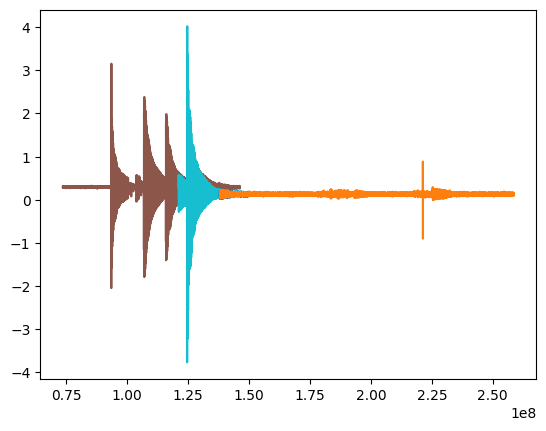

In [58]:

for phone in data.keys():
    print(phone)
    N = len(data[phone])
    a = np.zeros(N)
    t = np.zeros(N)
    for i in range(N):
        a[i] = data[phone][i][1]
        t[i] = data[phone][i][0]

    print(phone,np.nansum(a))
    plt.plot(t,a)
#plt.xlim([3.5*10**8,6*10**8])

In [68]:
phone = 44
N = len(data[phone])
print(N)
a = []
t = []
for i in range(N):
    if float(data[phone][i][0])>0:
        a.append(float(data[phone][i][1]))
        t.append(float(data[phone][i][0]))
print(len(t))
#plt.plot(t,a)

720000
11258


(0.0, 5000.0)

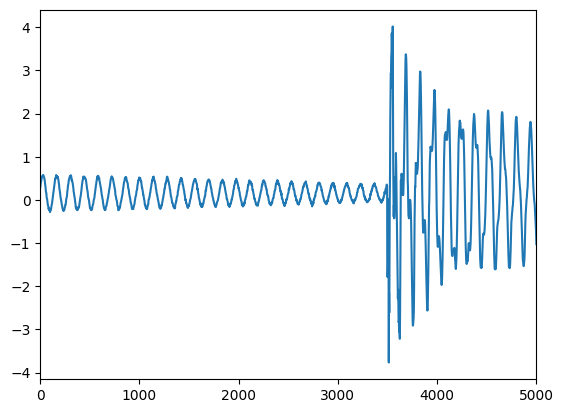

In [75]:
t = np.asarray(t)
a = np.asarray(a)
plt.plot((t-t[0])/1000,a)
plt.xlim([0,5*10**3])

In [ ]:
filelist = subprocess.run(['adb','devices'],text=True,stdout=True)

In [ ]:
name = 'experiment-2024-11-21T17_53_17-android.sensor.gyroscope-1-7082360130--1.csv'
savefile = "/Users/stephane/Documents/Telephones/2024_Jules_Caso/gyroscope.csv"
filelist = subprocess.run(['adb','-s',ip, 'pull',f"storage/self/primary/Download/SensorDumper/{name}",savefile],text=True,stdout=True,)

In [ ]:
import icewave.tools.rw_data as rw_data

filename = "/Users/stephane/Documents/Telephones/2024_Jules_Caso/gyroscope.csv"
data = rw_data.read_csv(filename)

In [ ]:
data = np.asarray(data)
plt.plot(data[:100,1].astype(float))

In [ ]:
a = plt.hist(np.diff(data[:10000,0].astype(int))/1000,100)
np.mean(np.diff(data[:10000,0].astype(int))/1000)

In [ ]:
np.mean(np.diff(np.asarray(data)[0,:10000].astype(int)))

In [ ]:
data = np.asarray(data)
data.shape

In [ ]:
data[0,:]

In [ ]:
t = data[:,0].astype(int)
acx = data[:,1].astype(float)
acy = data[:,2].astype(float)
acz = data[:,3].astype(float)

fig,ax = plt.subplots(figsize=(20,5))
ax.plot((t-t[0])/1000000,acz)
plt.xlim([0,1200])
g = 9.81
plt.ylim([-0.2+g,0.2+g])